In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as plt

In [12]:
#cargamos el dataset de viento
datos = pd.read_excel('wind_data.xlsx')

#visualizamos el dataset
datos.head()

3650


### Regresion Lineal

Vamos a estimar los parámetros \(\kappa\) y \(\sigma\) para el modelo de velocidad del viento utilizando regresiones lineales. La ecuación original es:

\[ S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i \]

Despejamos \( S_i \) y distribuimos los términos para obtener una forma adecuada para la regresión lineal:

\[ S_{i+1} - S_i = \kappa \theta(t_i) \Delta - \kappa S_i \Delta + \sigma \sqrt{\Delta} Z_i \]

Reescribimos la ecuación en términos de \(\beta\):

\[ \Delta S_i = \beta_0 + \beta_1 \theta(t_i) \Delta + \beta_2 S_i \Delta + \epsilon_i \]

donde:
- \(\Delta S_i = S_{i+1} - S_i\)
- \(\beta_0\) es la constante
- \(\beta_1 = \kappa\)
- \(\beta_2 = -\kappa\)
- \(\epsilon_i = \sigma \sqrt{\Delta} Z_i\)

In [ ]:
# S_i+1 - S_i = kappa*delta*theta - kappa*delta *S_i + sigma*raiz(delta)*Z

# Y = B0 + B1x + error

In [4]:
datos['Y'] = datos['regional wind'].diff()  # Calcula la diferencia entre días consecutivos

# Preparar X, que es S_i (el viento en el día i)
datos['X'] = datos['regional wind'].shift(1)

# Eliminar los valores nulos generados por diff() y shift()
datos = datos.dropna(subset=['Y', 'X'])

datos.head()

,dia,regional wind,wind gap norte sur,Y,X
1,2,8.346296,0.181523,0.346296,8.000000
2,3,10.062316,0.188643,1.716019,8.346296
3,4,10.791337,0.071085,0.729021,10.062316
4,5,10.754093,0.078442,-0.037244,10.791337
5,6,10.771457,0.642188,0.017364,10.754093


### Ejercicio 1

In [5]:
X = datos[['X']]  # La variable independiente es X = S_i
Y = datos['Y']    # La variable dependiente es Y = S_{i+1} - S_i

model = LinearRegression()
model.fit(X, Y)

B0 = model.intercept_
B1 = model.coef_[0]

print(f"B0: {B0}")
print(f"B1: {B1}")

delta = 1/365
kappa_estimado = -B1 / delta
print(f"kappa: {kappa_estimado}")

B0: 0.7614606979670508
B1: -0.1277369362965266
kappa: 46.62398174823221


In [6]:
# Preparar H, que es D_{i+1} - D_i
datos['H'] = datos['wind gap norte sur'].diff()

# Eliminar los valores nulos generados por diff()
datos = datos.dropna(subset = ('H'))

datos.head()

,dia,regional wind,wind gap norte sur,Y,X,H
2,3,10.062316,0.188643,1.716019,8.346296,0.007120
3,4,10.791337,0.071085,0.729021,10.062316,-0.117558
4,5,10.754093,0.078442,-0.037244,10.791337,0.007358
5,6,10.771457,0.642188,0.017364,10.754093,0.563745
6,7,9.527320,0.018175,-1.244136,10.771457,-0.624012


In [7]:
X = datos[['H']]  # La variable independiente es X = D_i
Y = datos['wind gap norte sur']    # La variable dependiente es Y = D_{i+1} - D_i

regresion_diferencia_regional = LinearRegression()
regresion_diferencia_regional.fit(X, Y)

B0 = regresion_diferencia_regional.intercept_
B1 = regresion_diferencia_regional.coef_[0]

print(f"B0: {B0}")
print(f"B1: {B1}")

delta = 1/365
gamma_estimado = -B1 / delta
print(f"gamma: {gamma_estimado}")

B0: 0.030743261641964354
B1: 0.5000116392982148
gamma: -182.5042483438484


### Ejercicio 2

In [8]:
def generar_camino(kappa, theta_func, sigma, delta, T):
    camino = np.zeros(T)
    camino[0] = theta_func(0)  #Valor inicial

    for i in range(1, T):
        Z = np.random.normal(0, 1)
        camino[i] = camino[i-1] + kappa * (theta_func(i) - camino[i-1]) * delta + camino[i-1] * sigma * np.sqrt(delta) * Z

    return camino

def theta_function(i):
    return 6 + 2 * np.cos(2 * np.pi * i / 365)

In [ ]:
import matplotlib.pyplot as plt

#Generamos 2 caminos con T = 365 uno para cada molino
T = 365

simulacion_molino_norte = generar_camino(kappa_estimado, theta_function(), sigma_estimado, delta, T)
simulacion_molino_sur = generar_camino(kappa_estimado, theta_function(), sigma_estimado, delta, T)


# Plotear los resultados con colores específicos
plt.plot(simulacion_molino_norte, color='red', label='Molino Norte')
plt.plot(simulacion_molino_sur, color='blue', label='Molino Sur')

# Añadir etiquetas y título
plt.xlabel('Días del año')
plt.ylabel('Velocidad del viento')
plt.title('Simulación de los molinos Norte y Sur')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

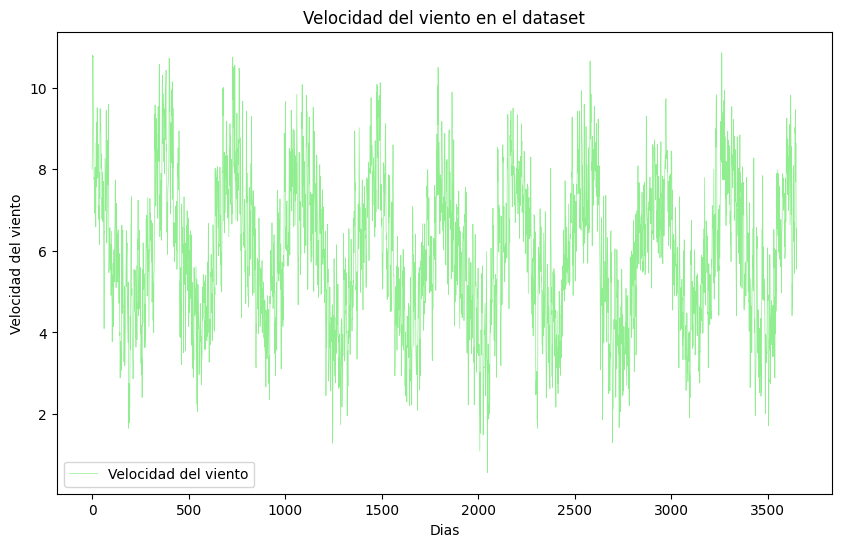

In [30]:
import matplotlib.pyplot as plt

# Graficar la velocidad del viento
plt.figure(figsize=(10, 6))
plt.plot(datos['regional wind'], color='lightgreen', label='Velocidad del viento', linewidth=0.5)

# Añadir etiquetas y título
plt.xlabel('Dias')
plt.ylabel('Velocidad del viento')
plt.title('Velocidad del viento en el dataset')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

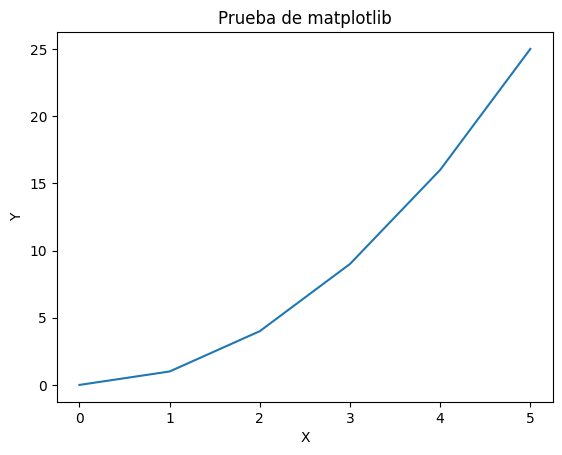

In [9]:
import matplotlib.pyplot as plt

# Crear algunos datos de prueba
x = [0, 1, 2, 3, 4, 5]
y = [0, 1, 4, 9, 16, 25]

# Graficar los datos
plt.plot(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Prueba de matplotlib')
plt.show()


In [ ]:
#Di+1 = Di −βDi∆ + γ√∆ W

def calcular_camino(beta, gamma, delta, T):
    diferencia = np.zeros(T)
    diferencia[0] = 0

    for i in range(1, T):
        W = np.random.normal(0, 1)
        diferencia[i] = 

    return diferencia